[*********************100%***********************]  13 of 13 completed


C:\Users\mehdi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_18396\3295848151.py:81: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  indicator = pd.Series(index=etf_oil_log_ratio.index)


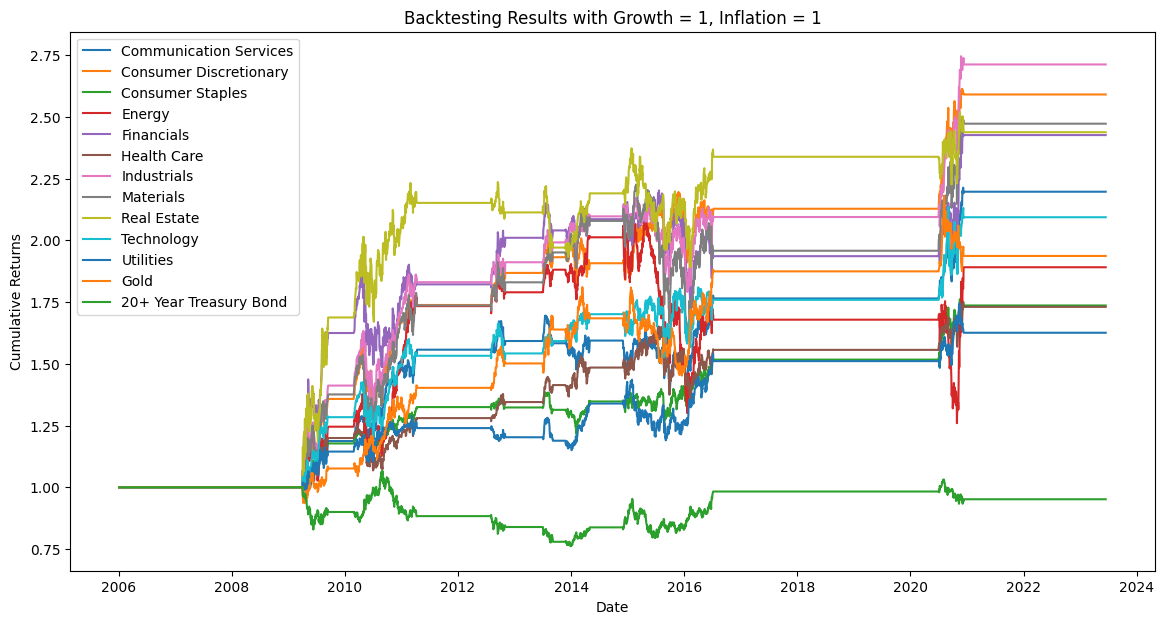

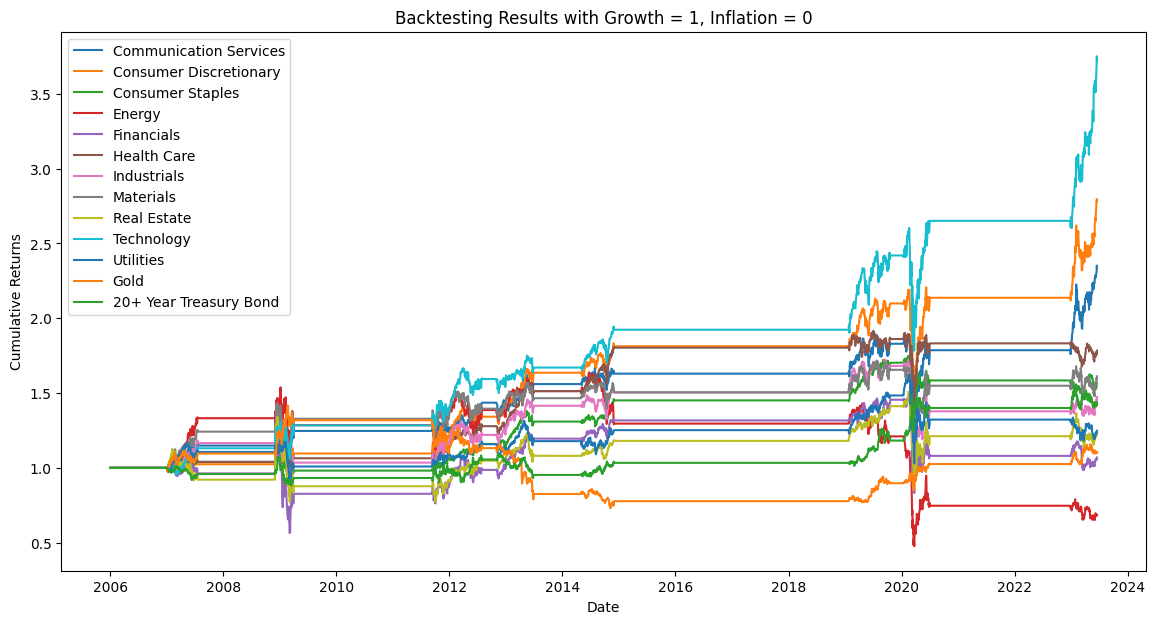

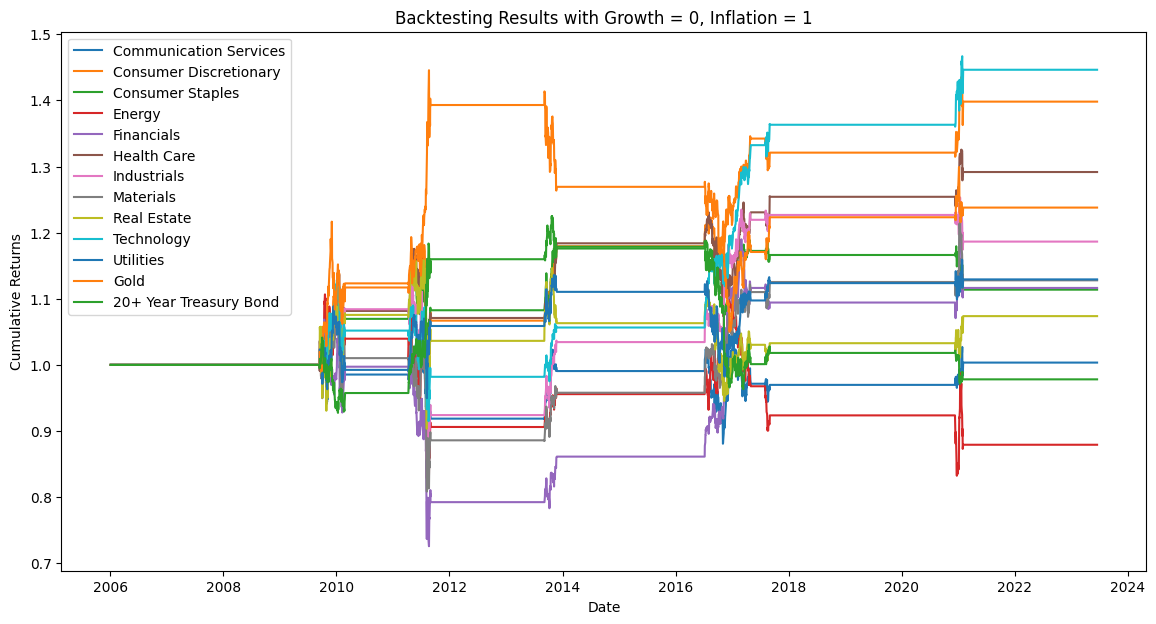

C:\Users\mehdi\AppData\Local\Temp\ipykernel_18396\3295848151.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'cumulative_returns_{comb}_{etf}'] = (1 + combined_df[f'daily_returns_{comb}_{etf}']).cumprod()
C:\Users\mehdi\AppData\Local\Temp\ipykernel_18396\3295848151.py:124: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'cumulative_returns_{comb}_{etf}'] = (1 + combined_df[f'daily_returns_{comb}_{etf}']).cumprod()
C:\Users\mehdi\AppData\Local\Temp\ipykernel_18396\3295848151.py:124: PerformanceWarnin

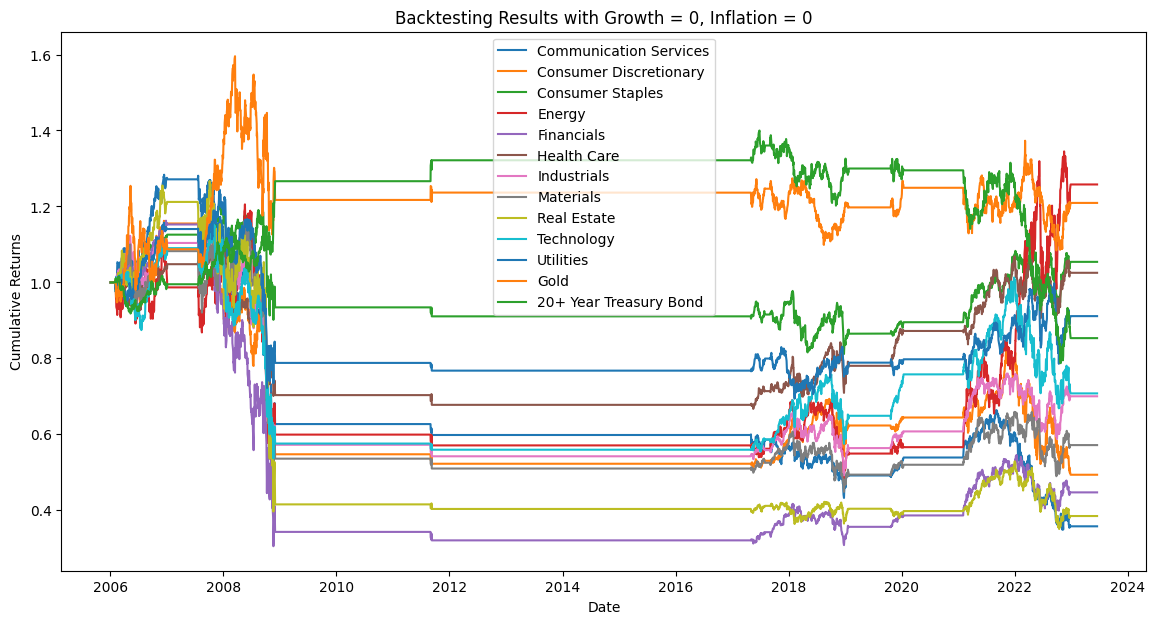

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression


def convert_date_to_ordinal(date):
    return date.toordinal()


def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]


# Define sector ETFs
sector_etfs = {
    "VOX": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "IYR": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities",
    "GLD": "Gold",
    "TLT": "20+ Year Treasury Bond"
}

# Fetch ETF data
etfs_data = yf.download(list(sector_etfs.keys()), start='2006-01-01', end='2023-06-19')
etf_close = etfs_data["Close"]

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')
# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Compute the inflation indicator for each data point
for i in range(12 * 7, len(cpi_df)):
    X = cpi_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = cpi_df['log_CPI'].iloc[:i].values

    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])

    model_7 = LinearRegression()
    model_7.fit(X[-12 * 7:], y[-12 * 7:])

    y_pred_1 = model_1.predict([X[-1]])
    y_pred_7 = model_7.predict([X[-1]])

    cpi_df.loc[cpi_df.index[i], 'inflation_indicator'] = 0 if y_pred_7[-1] < y_pred_1[-1] else 1

# Merge datasets
combined_df = etf_close.join(cpi_df['inflation_indicator'], how='left').fillna(method='ffill')

# Fetch WTI Crude Oil Price data
oil_price = fred.get_series('DCOILWTICO')
# Remove or fill in missing values
oil_price = oil_price.dropna()
# Calculate the logarithms
oil_log = np.log(oil_price)
# Compute the ratio of the logarithm of ETF prices and oil price
etf_oil_log_ratio = np.log(etf_close).div(oil_log, axis=0)

# Compute the 1-year and 7-year slopes for each day
indicator = pd.Series(index=etf_oil_log_ratio.index)

for date in etf_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_log_ratio = etf_oil_log_ratio[(etf_oil_log_ratio.index >= one_year_ago) & (etf_oil_log_ratio.index < date)]
    if not last_year_log_ratio.empty:
        X1 = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_log_ratio.mean(axis=1).values
        valid_indices = ~np.isnan(y1)
        X1 = X1[valid_indices]
        y1 = y1[valid_indices]
        if len(y1) > 0:
            one_year_slope = calculate_slope(X1, y1)
            seven_years_ago = date - DateOffset(years=7)
            last_seven_years_log_ratio = etf_oil_log_ratio[
                (etf_oil_log_ratio.index >= seven_years_ago) & (etf_oil_log_ratio.index < date)]
            if not last_seven_years_log_ratio.empty:
                X7 = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
                y7 = last_seven_years_log_ratio.mean(axis=1).values
                valid_indices = ~np.isnan(y7)
                X7 = X7[valid_indices]
                y7 = y7[valid_indices]
                if len(y7) > 0:
                    seven_years_slope = calculate_slope(X7, y7)
                    indicator[date] = int(one_year_slope > seven_years_slope)

# Combine the ETF closing prices and the indicators into one DataFrame
combined_df['growth_indicator'] = indicator

# Calculate the daily returns for each combination of indicators for each sector
for sector in sector_etfs:
    combined_df[f'daily_returns_11_{sector}'] = combined_df[sector].pct_change() * (combined_df['growth_indicator'].shift(1) == 1) * (combined_df['inflation_indicator'].shift(1) == 1)
    combined_df[f'daily_returns_10_{sector}'] = combined_df[sector].pct_change() * (combined_df['growth_indicator'].shift(1) == 1) * (combined_df['inflation_indicator'].shift(1) == 0)
    combined_df[f'daily_returns_01_{sector}'] = combined_df[sector].pct_change() * (combined_df['growth_indicator'].shift(1) == 0) * (combined_df['inflation_indicator'].shift(1) == 1)
    combined_df[f'daily_returns_00_{sector}'] = combined_df[sector].pct_change() * (combined_df['growth_indicator'].shift(1) == 0) * (combined_df['inflation_indicator'].shift(1) == 0)

# Calculate and Plot the cumulative returns for each combination of indicators for each sector
combinations = ['11', '10', '01', '00']
titles = ['Growth = 1, Inflation = 1', 'Growth = 1, Inflation = 0', 'Growth = 0, Inflation = 1', 'Growth = 0, Inflation = 0']

for comb, title in zip(combinations, titles):
    plt.figure(figsize=(14, 7))
    for etf, sector in sector_etfs.items():
        combined_df[f'cumulative_returns_{comb}_{etf}'] = (1 + combined_df[f'daily_returns_{comb}_{etf}']).cumprod()
        plt.plot(combined_df[f'cumulative_returns_{comb}_{etf}'], label=f'{sector}')
    plt.title(f'Backtesting Results with {title}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()
